In [1]:
from Bio import AlignIO
from Bio.Align.Applications import ClustalOmegaCommandline
import pandas as pd
from Bio.Phylo.TreeConstruction import _Matrix
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio.Phylo.TreeConstruction import _DistanceMatrix
from Bio.Phylo import draw
from Bio.Phylo.Applications import PhymlCommandline
from Bio.Align import MultipleSeqAlignment

C:\Users\Marce\anaconda3\Lib\site-packages\Bio\Application\__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [15]:



import pandas as pd
vcf_original = 'multisample.vcf'

# Leer el archivo VCF para realizar el muestreo
df = pd.read_csv(vcf_original, sep='\t', comment='#')

# Realizar el muestreo
df_sampled = df.sample(n=10000, random_state=30)

# Guardar el DataFrame muestreado como un archivo CSV temporal
df_sampled.to_csv('snp10k_temp.vcf', sep='\t', index=False)

# Abrir el archivo original VCF y leer las primeras 4964 líneas (metadatos)
with open(vcf_original, 'r') as f:
    metadatos = [next(f) for _ in range(4964)]

# Abrir el archivo filtrado VCF en modo escritura y añadir las líneas de metadatos
with open('snp10k_temp.vcf', 'r') as f_in:
    with open('snp10k.vcf', 'w') as f_out:
        for linea in metadatos:
            f_out.write(linea)
        for linea in f_in:
            f_out.write(linea)

# Eliminar el archivo temporal
import os
os.remove('snp10k_temp.vcf')

In [9]:
# En esta celda, leemos cada vcf subsampleado como objeto de pandas, le agregamos una fila con los títulos y filtramos las columnas de interés para armar la tabla de la que vamos a inferir secuencias

#para leer el vcf como dataframe:
# Leer el archivo VCF y asignar los nombres de las columnas
titulos = ["contig", "pos", "brr", "REF", "ALT", "DP", "COND", "A", "B", "Blue13", "Eg73", "P13626", "LBUS5", "US8", "US23", "HN1602", "Kr1", "Kr2", "PiNSL", "HB1501", "P_mirabilis", "DDR7602"]

vcf_anotado = "snp500k.vcf"
df = pd.read_csv(vcf_anotado, sep='\t', names= titulos, comment='#')

# Obtener los nombres de las columnas de las muestras
nombres_columnas_muestras = list(df.columns[10:])

#Hacer una subtabla que elimine columnas que no vamos a usar

df2 = df[["REF", "ALT", "Blue13", "Eg73", "P13626", "LBUS5", "US8", "US23", "HN1602", "Kr1", "Kr2", "PiNSL", "HB1501", "P_mirabilis", "DDR7602"]]

print(df2)

       REF ALT                                 Blue13  \
0        T   C                      ./.:.:.:.:.:.:.:.   
1        T   A                      ./.:.:.:.:.:.:.:.   
2        G   A  0/1:109,0,28:10:0:2,0,5,3:2,5:0,3:2,8   
3        T   G                      ./.:.:.:.:.:.:.:.   
4        A   G                      ./.:.:.:.:.:.:.:.   
...     ..  ..                                    ...   
499996   C   A                      ./.:.:.:.:.:.:.:.   
499997   A   G  0/1:78,0,113:11:3:1,5,2,3:1,2:5,3:6,5   
499998   A   T                      ./.:.:.:.:.:.:.:.   
499999   C   T                      ./.:.:.:.:.:.:.:.   
500000   T   C                      ./.:.:.:.:.:.:.:.   

                                                Eg73  \
0       0/1:96,0,168:33:23:5,13,12,3:5,12:13,3:18,15   
1                                  ./.:.:.:.:.:.:.:.   
2                                  ./.:.:.:.:.:.:.:.   
3           0/1:118,0,196:28:0:8,6,7,7:8,7:6,7:14,14   
4          0/1:68,0,144:16:36:0,11,

In [10]:
# Crear un diccionario para almacenar las bases por muestra
bases_por_muestra = {muestra: '' for muestra in df2.columns[2:]}

# Iterar sobre cada fila del DataFrame
for indice, fila in df2.iterrows():
    # Obtener las bases de referencia y alternativa
    base_ref = fila['REF']
    base_alt = fila['ALT']
    
    # Iterar sobre cada muestra
    for muestra in df2.columns[2:]:
        # Obtener el valor de la muestra en la fila actual
        valor_muestra = fila[muestra]
        
        # Determinar qué base agregar al valor de la muestra
        if valor_muestra == './.:.:.:.:.:.:.:.':
            # Agregar la base de referencia si no hay llamada para esa muestra
            bases_por_muestra[muestra] += base_ref
        elif valor_muestra.startswith('0/1'):
            # Agregar la base alternativa en minúscula si es heterocigota
            bases_por_muestra[muestra] += base_alt.lower()
        elif valor_muestra.startswith('1/1'):
            # Agregar la base alternativa en mayúscula si es homocigota
            bases_por_muestra[muestra] += base_alt.upper()

# Verificar el diccionario resultante
print(bases_por_muestra["Blue13"])


TTaTACGCCGCCAgg,tGTCAGTGAACCAAGCTGGCTATGTTTGACTCTCAGGTGGaACTGCTAAACTCTTCGAaACAATCATTGATCTTGTAGCCAGCGGTAGGCCGCCTTTATAGCCGTTCCCACGTGGGCGAGGAGTCTCTGCACGAAACTGAAAAAACTtCGAGACCCTATGTCCATACATCGCATTGGCTTGGACTACGTGGCTGATGATGCGgCCTGCCGCAGTTAGAGCTTACAAAGGCTTAAAAACAgCTcGTGGTCGGCGCTATTTTATTGATCCGCTTATTGGTCATGGTGCGGCCGTCTGgtcCACCCCGTTGGGTTAGGGTGCTACACATTCATATAGGTGACAGCCAGGGcAGCAATGTAGCAGCAGTTACATCAGCTTACTACAGGACTATtTGCtCTCTCGCAAgAAACCAACTTGGCCCGGATCTAGTTGGGaAAGCCACATTAGTTCGGCACGTAGCCAACCGGGATCTCTtaaCACCATACATGATGGCAAGCACATTCGCTGGCGCATGCTTAGCCGGCATTATCAATAGATGGTAGTATTCGCATATATTCACGGAGAGTGGGACAAGCCAGTAAGGCACCGTGGTCCGCATACGCAAGCTCCCTGAAACGGCtTGAGATAGCGCGTATGATGGAATGCCAgAATAAATCTACAAGTAGCCCTTAAAGTTCCAGGTTTAATAATGAGATAGTCAGGGCCTGGGTCACTaGGAAGTGACCATTAGAGCAAATCCCACCCTGCCTTCATGTTTTACTAGCTTTCGGACTTTTAg,aTGGTTATCGTTGTGTATGACACCGAGAGACACCTCCATGAATATGCCGCcTCAGTTAGTTATCAATTAAGaGTTGCTCCCGGCGAGgGGCCACTGAcTGAATGAAGGCGCGCGTGCGTTGGCACGTGCCCGGATTGTAATATCTCCTCGCGGACACTGAATATCTGAGCCATGtAAACTTGCTGgGTTCATAGTAGAATaCAGGAG

In [12]:
# Diccionario para almacenar las bases filtradas por muestra
bases_filtradas_por_muestra = {}

for muestra, bases in bases_por_muestra.items():
    bases_filtradas = ''.join(base for base in bases if base.upper() in ['A', 'C', 'G', 'T'])
    bases_filtradas_por_muestra[muestra] = bases_filtradas



# Nombre del archivo de salida en formato fasta
archivo_salida = "multisample.fasta"

# Abrir el archivo de salida en modo de escritura
with open(archivo_salida, "w") as fasta_file:
    # Iterar sobre las claves y valores del diccionario
    for muestra, secuencia in bases_filtradas_por_muestra.items():
        # Escribir el encabezado FASTA con el nombre de la muestra
        fasta_file.write(f">{muestra}\n")
        # Escribir la secuencia en el archivo FASTA, con un ancho máximo de 80 caracteres por línea
        for i in range(0, len(secuencia), 80):
            fasta_file.write(secuencia[i:i+80] + "\n")


In [6]:
from Bio import AlignIO
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor



In [7]:
import subprocess

def run_mafft(input_fasta_file, output_fasta_file):
    # Ruta completa al ejecutable de MAFFT
    mafft_path = "mafft.bat"
    # Comando MAFFT
    mafft_command = f"{mafft_path} --auto {input_fasta_file}"

    # Ejecutar el comando
    process = subprocess.run(mafft_command, shell=True, check=True, text=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    if process.returncode != 0:
        print(f"Hubo un error al ejecutar MAFFT: {process.stderr}")
    else:
        with open(output_fasta_file, 'w') as f:
            f.write(process.stdout)
        print(f"El alineamiento se realizó correctamente y se guardó en {output_fasta_file}")

# Ejemplo de uso
run_mafft("10k.fasta", "align_10k.fasta")

El alineamiento se realizó correctamente y se guardó en align_10k.fasta


In [2]:

################################################################################################################################################################
################################################################################################################################################################
#     En este punto, utilizando el software PhyML construímos mil árboles por máxima verosimilitud y guardamos el más probable en formato newick,
#      para terminar el análisis
 

################################################################################################################################################################
################################################################################################################################################################


#convertir el alineamiento en formato fasta en un alineamiento en formato phyllip
# Importa las bibliotecas necesarias
from Bio import SeqIO

# Carga el archivo FASTA alineado
records = SeqIO.parse("multialign.fasta", "fasta")

# Escribe las secuencias en formato PHYLIP
with open("multialign.phy", "w") as output_file:
    SeqIO.write(records, output_file, "phylip")

In [8]:
import subprocess

def run_phyml():
    # Define el comando y las respuestas a las preguntas
    cmd = 'phyml.bat'
    answers = ['10k_sinout.phy', 'Y']
    # Crea un objeto Popen con pipes para stdin, stdout y stderr
    proc = subprocess.Popen(cmd, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    # Escribe las respuestas en stdin y cierra stdin
    proc.stdin.write('\n'.join(answers).encode())
    proc.stdin.close()

    # Espera a que el proceso termine y obtén stdout y stderr
    stdout, stderr = proc.communicate()
    # Imprime stdout y stderr
    print(stdout.decode())
    if stderr:
        print("Errors:")
        print(stderr.decode())

# Llama a la función
run_phyml()


C:\Users\Marce\Desktop\trabajofinal>PhyML-3.1_win32


 oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
                                                                                                  
                                 ---  PhyML 20120412  ---                                             
                                                                                                  
    A simple, fast, and accurate algorithm to estimate large phylogenies by maximum likelihood    
                            Stephane Guindon & Olivier Gascuel                                      
                                                                                                  
                           http://www.atgc-montpellier.fr/phyml                                          
                                                                                                  
                         Copyright CNRS 

<Figure size 800x800 with 0 Axes>

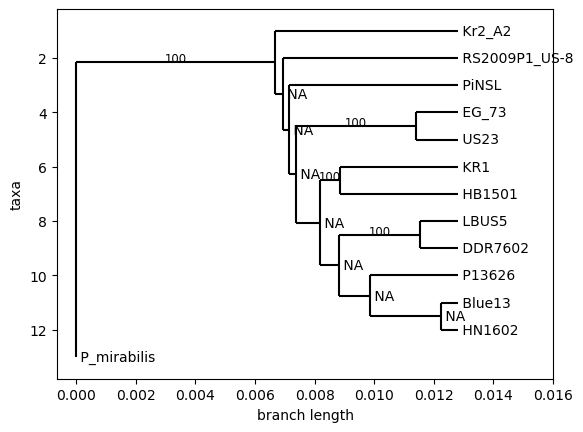

In [4]:
#obtenidas las secuencias de los fastas, me mudo a bash para utilizar el softwware mafft para hacer el alineamiento múltiple. Creo el árbol por Maximum Likelyhood

from Bio import Phylo
import matplotlib.pyplot as plt

# Leer el árbol desde el archivo en formato Newick
tree = Phylo.read("Phys200k.nwk", "newick")


# Encontrar el clado que contiene la muestra deseada (por ejemplo, "P_mirabilis")
root_clade = None
for clade in tree.find_clades():
    if clade.name is not None and "P_mirabilis" in clade.name:
        root_clade = clade
        break

# Enraizar el árbol en el clado encontrado
if root_clade:
    tree.root_with_outgroup(root_clade)


plt.figure(figsize=(8, 8))  # Tamaño personalizado para el gráfico
plt.suptitle("Maximum likelihood 100k SNPs", fontsize=14)  # Título del gráfico
Phylo.draw(tree, do_show=False)
plt.show()

<Figure size 800x800 with 0 Axes>

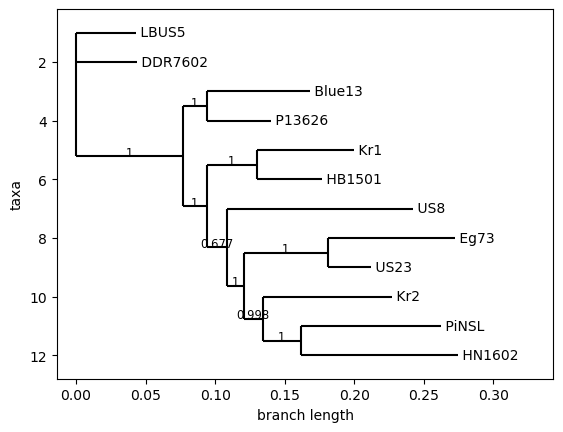

In [7]:
import io
from Bio import Phylo
import matplotlib.pyplot as plt
from Bio.Phylo.BaseTree import Clade
from Bio.Phylo.BaseTree import Tree


arbol_ML = "(LBUS5:0.04283550,DDR7602:0.04407856,((Blue13:0.07428463,P13626:0.04659946)1.000000:0.01710212,((Kr1:0.06985160,HB1501:0.04678287)1.000000:0.03632512,(US8:0.13373212,((Eg73:0.09118816,US23:0.03086526)1.000000:0.06046944,(Kr2:0.09318384,(PiNSL:0.10096519,HN1602:0.11267978)1.000000:0.02753235)0.998000:0.01356104)1.000000:0.01237669)0.677000:0.01426253)1.000000:0.01715481)1.000000:0.07670227);"

str_io = io.StringIO(arbol_ML)
tree = Phylo.read(str_io, "newick")

# Encontrar el clado que contiene la muestra deseada (por ejemplo, "P_mirabilis")
root_clade = None
for clade in tree.find_clades():
    if clade.name is not None and "P_mirabilis" in clade.name:
        root_clade = clade
        break

# Enraizar el árbol en el clado encontrado
if root_clade:
    tree.root_with_outgroup(root_clade)

plt.figure(figsize=(8, 8))  # Tamaño personalizado para el gráfico
plt.suptitle("Maximum likelihood 100k SNPs", fontsize=14)  # Título del gráfico
Phylo.draw(tree, do_show=False)
# Guardamos la figura como una imagen PNG sin fondo
plt.savefig("snp200k_arbol_ML_sinout.png", format='png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()